In [1]:
import pandas as pd
import string
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
# Load the datasets
news_df = pd.read_csv('./data/us_equities_news_dataset.csv')
stock_df = pd.read_csv('./data/NVDA.csv')



In [4]:
# Display general information about the datasets
print("News Dataset Info:")
print(news_df.info())
print("\nStock Dataset Info:")
print(stock_df.info())

News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221513 entries, 0 to 221512
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            221513 non-null  int64 
 1   ticker        221513 non-null  object
 2   title         221513 non-null  object
 3   category      221513 non-null  object
 4   content       221505 non-null  object
 5   release_date  221513 non-null  object
 6   provider      221513 non-null  object
 7   url           221513 non-null  object
 8   article_id    221513 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 15.2+ MB
None

Stock Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6437 entries, 0 to 6436
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6437 non-null   object 
 1   Open       6437 non-null   float64
 2   High       6437 non-null   float64
 3   Low       

News dataset has 9 columns: ID, Ticker shows the company that the article is referring to, Title is the article title, category is the type of news, content is the article itself, publishedAt is the date of publication, source is the source of the article, url is the link to the article, summary is a summary of the article and related is the related news to the article. The dataset has 1000 rows.

Stock dataset has 7 columns, Date is the date of the stock price, Open is the opening price of the stock, High is the highest price of the stock, Low is the lowest price of the stock, Close is the closing price of the stock, Adj Close is the adjusted closing price of the stock and Volume is the volume of the stock. The dataset has 1259 rows.

In [5]:
# Display the first few rows of each dataset
print("\nFirst few rows of the News Dataset:")
print(news_df.head())
print("\nFirst few rows of the Stock Dataset:")
print(stock_df.head())


First few rows of the News Dataset:
       id ticker                                              title category  \
0  221515    NIO  Why Shares of Chinese Electric Car Maker NIO A...     news   
1  221516    NIO  NIO only consumer gainer  Workhorse Group amon...     news   
2  221517    NIO  NIO leads consumer gainers  Beyond Meat and Ma...     news   
3  221518    NIO                  NIO  NVAX among premarket gainers     news   
4  221519    NIO                  PLUG  NIO among premarket gainers     news   

                                             content release_date  \
0  What s happening\nShares of Chinese electric c...   2020-01-15   
1  Gainers  NIO  NYSE NIO   7  \nLosers  MGP Ingr...   2020-01-18   
2  Gainers  NIO  NYSE NIO   14   Village Farms In...   2020-01-15   
3  Cemtrex  NASDAQ CETX   85  after FY results \n...   2020-01-15   
4  aTyr Pharma  NASDAQ LIFE   63  on Kyorin Pharm...   2020-01-06   

          provider                                                u

In [6]:
# Check for missing values in the datasets
print("\nMissing values in News Dataset:")
print(news_df.isnull().sum())
print("\nMissing values in Stock Dataset:")
print(stock_df.isnull().sum())




Missing values in News Dataset:
id              0
ticker          0
title           0
category        0
content         8
release_date    0
provider        0
url             0
article_id      0
dtype: int64

Missing values in Stock Dataset:
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [7]:
# Summary statistics for numerical columns in stock data
print("\nSummary statistics for Stock Dataset:")
print(stock_df.describe())



Summary statistics for Stock Dataset:
              Open         High          Low        Close    Adj Close  \
count  6437.000000  6437.000000  6437.000000  6437.000000  6437.000000   
mean      6.492829     6.614421     6.362843     6.495542     6.469240   
std      17.045341    17.370931    16.677118    17.044818    17.047936   
min       0.034896     0.035547     0.033333     0.034115     0.031291   
25%       0.277865     0.286458     0.270250     0.277333     0.254377   
50%       0.458417     0.465750     0.451750     0.458333     0.428777   
75%       4.214750     4.271500     4.155000     4.218000     4.186831   
max     139.800003   140.759995   132.419998   135.580002   135.580002   

             Volume  
count  6.437000e+03  
mean   6.050942e+08  
std    4.312372e+08  
min    1.968000e+07  
25%    3.449760e+08  
50%    5.066160e+08  
75%    7.356200e+08  
max    9.230856e+09  


In [9]:
print(news_df['ticker'].unique())
print(news_df['ticker'].value_counts())


['NIO' 'UBER' 'CTL' 'INTC' 'MSFT' 'MU' 'BLDP' 'FCX' 'EQT' 'MRVL' 'TFC'
 'MAS' 'KLAC' 'ES' 'LHX' 'NUE' 'CB' 'ALNY' 'CLSN' 'TV' 'FMC' 'DNKN'
 'WFTLF' 'ASGN' 'CHCI' 'AMSF' 'TAOP' 'CECE' 'CTHR' 'CNTFY' 'EDMCQ' 'ECOL'
 'EBMT' 'DYNT' 'DYSL' 'DXYN' 'DWSN' 'DUSA' 'DXPE' 'DSWL' 'DSG' 'DSPG'
 'DRAD' 'DORM' 'DMRC' 'DNBF' 'DJCO' 'DISCB' 'DGICA' 'DGICB' 'DCIX' 'DCTHD'
 'BBQ' 'DAIO' 'CZFC' 'CYTR' 'CWBC' 'CYAN' 'CVV' 'CVCO' 'CVCY' 'CVLY'
 'BSRR' 'CTWS' 'BVSN' 'HKTVY' 'CRZO' 'CSPI' 'CRWS' 'CRAY' 'CRMBQ' 'CRMT'
 'CRAI' 'CPSI' 'CPSS' 'CPIX' 'TRCB' 'CPHC' 'VIEWF' 'ASFI' 'ARTX' 'CNET'
 'DXLG' 'CNAF' 'CLRO' 'CLMT' 'CLFD' 'CIDM' 'CIZN' 'PME' 'CHOPF' 'CFNB'
 'CFFI' 'CENT' 'CFBK' 'CCUR' 'CCRN' 'CCBG' 'CBAT' 'CBAN' 'CART' 'CARV'
 'CARB' 'CAAS' 'PTVCB' 'BYFC' 'CALI' 'CACH' 'BWEN' 'BSPM' 'BSQR' 'BRID'
 'INFY' 'NBL' 'PEG' 'IRM' 'ALL' 'MAR' 'EW' 'ALGN' 'CUTR' 'CHEF' 'BXP'
 'BEAT' 'AXTI' 'CTRN' 'BELFB' 'CGA' 'CCNE' 'BNSO' 'AMRB' 'BOSC' 'NFLX'
 'BX' 'PM' 'GE' 'FIS' 'COST' 'GS' 'LRCX' 'MKC' 'ETR' 'NDAQ' 'CSOD' 'SNA'


In [13]:
# Count the occurrences of each ticker
ticker_counts = news_df['ticker'].value_counts()

# Filter to keep only tickers that occur exactly once
single_occurrence_tickers = ticker_counts[ticker_counts == 1].index

# Count the number of rows in the DataFrame where the ticker occurs only once
unique_ticker_count = news_df[news_df['ticker'].isin(single_occurrence_tickers)].shape[0]

# Display the count
print(f"Number of rows where the ticker occurs only once: {unique_ticker_count}")


Number of rows where the ticker occurs only once: 12


In [14]:
# Count the occurrences of each ticker
ticker_counts = news_df['ticker'].value_counts()

# Filter to keep only tickers that occur exactly once
single_occurrence_tickers = ticker_counts[ticker_counts == 2].index

# Count the number of rows in the DataFrame where the ticker occurs only once
unique_ticker_count = news_df[news_df['ticker'].isin(single_occurrence_tickers)].shape[0]

# Display the count
print(f"Number of rows where the ticker occurs only once: {unique_ticker_count}")

Number of rows where the ticker occurs only once: 32


In [15]:
# Count the occurrences of each ticker
ticker_counts = news_df['ticker'].value_counts()

# Filter to keep only tickers that occur exactly once
single_occurrence_tickers = ticker_counts[ticker_counts == 3].index

# Count the number of rows in the DataFrame where the ticker occurs only once
unique_ticker_count = news_df[news_df['ticker'].isin(single_occurrence_tickers)].shape[0]

# Display the count
print(f"Number of rows where the ticker occurs only once: {unique_ticker_count}")

Number of rows where the ticker occurs only once: 33


In [16]:
# Count the occurrences of each ticker
ticker_counts = news_df['ticker'].value_counts()

# Filter to keep only tickers that occur exactly once
single_occurrence_tickers = ticker_counts[ticker_counts == 4].index

# Count the number of rows in the DataFrame where the ticker occurs only once
unique_ticker_count = news_df[news_df['ticker'].isin(single_occurrence_tickers)].shape[0]

# Display the count
print(f"Number of rows where the ticker occurs only once: {unique_ticker_count}")

Number of rows where the ticker occurs only once: 56


In [30]:
# Count the occurrences of each ticker
ticker_counts = news_df['ticker'].value_counts()

# Filter to keep tickers that occur between 1 and 5 times
range_occurrence_tickers = ticker_counts[ticker_counts.between(1, 5)].index

# Display the number of unique tickers within the specified range
unique_ticker_count = len(range_occurrence_tickers)
print(f"Number of unique tickers that occur between 1 and 10 times: {unique_ticker_count}")

# To get the number of rows in the DataFrame for these tickers:
# Filter the rows in the DataFrame where the ticker count is between 1 and 5
range_ticker_rows = news_df[news_df['ticker'].isin(range_occurrence_tickers)]

# Display the count of rows where tickers occur within the specified range
range_ticker_row_count = range_ticker_rows.shape[0]
print(f"Number of rows where the ticker occurs between 1 and 10 times: {range_ticker_row_count}")


Number of unique tickers that occur between 1 and 10 times: 64
Number of rows where the ticker occurs between 1 and 10 times: 188


In [24]:
import pandas as pd

# Sample keywords related to NVIDIA and associated companies
nvidia_keywords = [
    'NVDA', 'NVIDIA', 'NIO', 'UBER', 'AMZN', 'AMAZON', 'TESLA', 'AI', 'GPU', 'GRAPHICS',
    'CHIP', 'SEMICONDUCTOR', 'AUTONOMOUS', 'DRIVING', 'AI', 'DEEP LEARNING', 'MACHINE LEARNING'
]

# Compile a regex pattern from the keywords list
nvidia_pattern = '|'.join(nvidia_keywords)  # Combines the keywords into a regex pattern

# Filter articles where the content or ticker column contains any of the keywords
nvidia_related_articles = news_df[
    news_df['content'].str.contains(nvidia_pattern, case=False, na=False) |
    news_df['ticker'].str.contains(nvidia_pattern, case=False, na=False)
]

# Display the first few rows of the NVIDIA-related articles
print("NVIDIA-Related Articles:")
print(nvidia_related_articles.head())

# Display the count of NVIDIA-related articles
print(f"\nTotal NVIDIA-related articles found: {nvidia_related_articles.shape[0]}")


NVIDIA-Related Articles:
       id ticker                                              title category  \
0  221515    NIO  Why Shares of Chinese Electric Car Maker NIO A...     news   
1  221516    NIO  NIO only consumer gainer  Workhorse Group amon...     news   
2  221517    NIO  NIO leads consumer gainers  Beyond Meat and Ma...     news   
3  221518    NIO                  NIO  NVAX among premarket gainers     news   
4  221519    NIO                  PLUG  NIO among premarket gainers     news   

                                             content release_date  \
0  What s happening\nShares of Chinese electric c...   2020-01-15   
1  Gainers  NIO  NYSE NIO   7  \nLosers  MGP Ingr...   2020-01-18   
2  Gainers  NIO  NYSE NIO   14   Village Farms In...   2020-01-15   
3  Cemtrex  NASDAQ CETX   85  after FY results \n...   2020-01-15   
4  aTyr Pharma  NASDAQ LIFE   63  on Kyorin Pharm...   2020-01-06   

          provider                                                url  \
0  The

In [31]:
# Sample keywords related to NVIDIA and associated companies
nvidia_keywords = [
    'NVDA', 'NVIDIA', 'NIO', 'UBER', 'AMZN', 'AMAZON', 'TESLA', 'AI', 'GPU', 'GRAPHICS',
    'CHIP', 'SEMICONDUCTOR', 'AUTONOMOUS', 'DRIVING', 'DEEP LEARNING', 'MACHINE LEARNING'
]

# Compile a regex pattern from the keywords list
nvidia_pattern = '|'.join(nvidia_keywords)  # Combines the keywords into a regex pattern

# Filter articles where the content or ticker column contains any of the keywords
nvidia_related_articles = news_df[
    news_df['content'].str.contains(nvidia_pattern, case=False, na=False) |
    news_df['ticker'].str.contains(nvidia_pattern, case=False, na=False)
]

# Display the count of NVIDIA-related articles
print(f"\nTotal NVIDIA-related articles found: {nvidia_related_articles.shape[0]}")

# Convert the date columns to datetime format for matching
nvidia_related_articles['Date'] = pd.to_datetime(nvidia_related_articles['release_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge filtered news data with stock prices based on publication date
merged_df = pd.merge(nvidia_related_articles, stock_df, on='Date', how='inner')

# Filter to keep only articles that have matching stock data
filtered_df = merged_df[['content', 'Open', 'Close', 'Date']]

# Label the target variable based on the opening and closing prices
filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)

# Display the first few rows to verify the merging and labeling
print("\nFiltered and Labeled Data:")
print(filtered_df.head())


Total NVIDIA-related articles found: 209131

Filtered and Labeled Data:
                                             content     Open    Close  \
0  What s happening\nShares of Chinese electric c...  6.19475  6.13925   
1  Gainers  NIO  NYSE NIO   14   Village Farms In...  6.19475  6.13925   
2  Cemtrex  NASDAQ CETX   85  after FY results \n...  6.19475  6.13925   
3  aTyr Pharma  NASDAQ LIFE   63  on Kyorin Pharm...  5.80800  5.92650   
4  Gainers  NIO  NYSE NIO   14   Meritor  NYSE MT...  5.77250  5.88250   

        Date  target  
0 2020-01-15       0  
1 2020-01-15       0  
2 2020-01-15       0  
3 2020-01-06       1  
4 2019-12-31       1  


C:\Users\georg\AppData\Local\Temp\ipykernel_55436\3343991108.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_related_articles['Date'] = pd.to_datetime(nvidia_related_articles['release_date'])
C:\Users\georg\AppData\Local\Temp\ipykernel_55436\3343991108.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['target'] = np.where(filtered_df['Open'] > filtered_df['Close'], 0, 1)


In [8]:
# Basic descriptive statistics for the news dataset
num_articles = news_df.shape[0]
average_words_per_article = news_df['content'].apply(lambda x: len(str(x).split())).mean()
print(f"The number of articles is:", num_articles)
print(f"The average amount of words per article is:",average_words_per_article)


The number of articles is: 221513
The average amount of words per article is: 593.3977148068059


In [9]:
# Text length analysis for news articles
news_df['text_length'] = news_df['content'].apply(lambda x: len(str(x).split()))
print(f"\nAverage text length of news articles: {average_words_per_article:.2f} words")


Average text length of news articles: 593.40 words


In [10]:
# Tokenize content for word frequency analysis
# Using dataframe.series.apply is optimal for performance as per this stackoverflow article https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame 

news_df['processed_text'] = news_df['content'].apply(lambda x: word_tokenize(str(x).lower()))

In [11]:
# Flatten the list of words for frequency analysis
all_words = [word for content in news_df['processed_text'] for word in content if word.isalpha()]

In [12]:

# Remove stopwords and punctuation for better NLP insights
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in all_words if word not in stop_words]

In [13]:
# Number of unique words and lexical richness
unique_words = set(filtered_words)
num_unique_words = len(unique_words)
lexical_richness = num_unique_words / len(filtered_words)
print(f"The number of unique words is :",num_unique_words)
print(f"The number of words is :",len(filtered_words))
print(f"The lexical richness is :",lexical_richness)

The number of unique words is : 261099
The number of words is : 74339555
The lexical richness is : 0.0035122486272617585


In [14]:
# Frequency analysis of the most common words
word_freq = Counter(filtered_words)
most_common_words = word_freq.most_common(50)


In [15]:
# Display the most common words in the news dataset
print("\nTop 50 most common words in the news articles (after stop word removal):")
print(most_common_words)


Top 50 most common words in the news articles (after stop word removal):
[('year', 782698), ('company', 609020), ('zacks', 550140), ('earnings', 545103), ('quarter', 446426), ('million', 362236), ('market', 352341), ('nyse', 350763), ('said', 349662), ('stocks', 345264), ('growth', 340129), ('billion', 313879), ('stock', 309927), ('u', 306092), ('also', 297995), ('nasdaq', 283242), ('new', 258213), ('rank', 258053), ('last', 253648), ('inc', 252909), ('expected', 224482), ('per', 220201), ('estimate', 214955), ('investors', 213993), ('share', 206731), ('percent', 204289), ('sales', 202868), ('consensus', 201089), ('price', 197400), ('one', 194272), ('shares', 191346), ('buy', 174155), ('first', 173036), ('may', 170830), ('would', 170574), ('time', 170510), ('companies', 168683), ('p', 166933), ('revenues', 165225), ('see', 164647), ('higher', 161567), ('week', 160717), ('could', 156967), ('strong', 156882), ('industry', 151378), ('report', 147955), ('business', 145401), ('reported', 1

In [16]:
# Display the general statistics and most common words
overview_stats = {
    'Number of Articles': num_articles,
    'Average Words per Article': average_words_per_article,
    'Number of Unique Words': num_unique_words,
    'Lexical Richness': lexical_richness
}

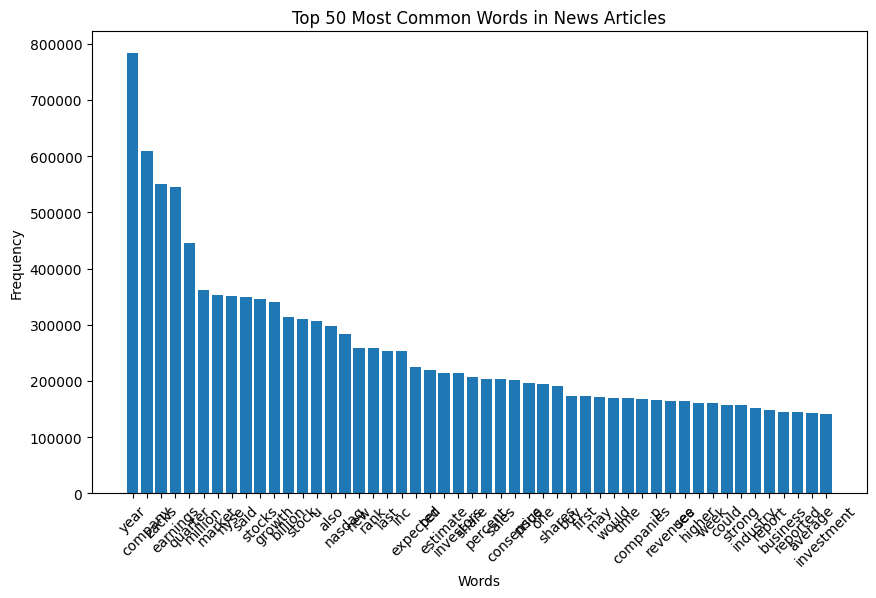

In [17]:
# Plot the frequency of the top 50 words
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_words))
plt.title("Top 50 Most Common Words in News Articles")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


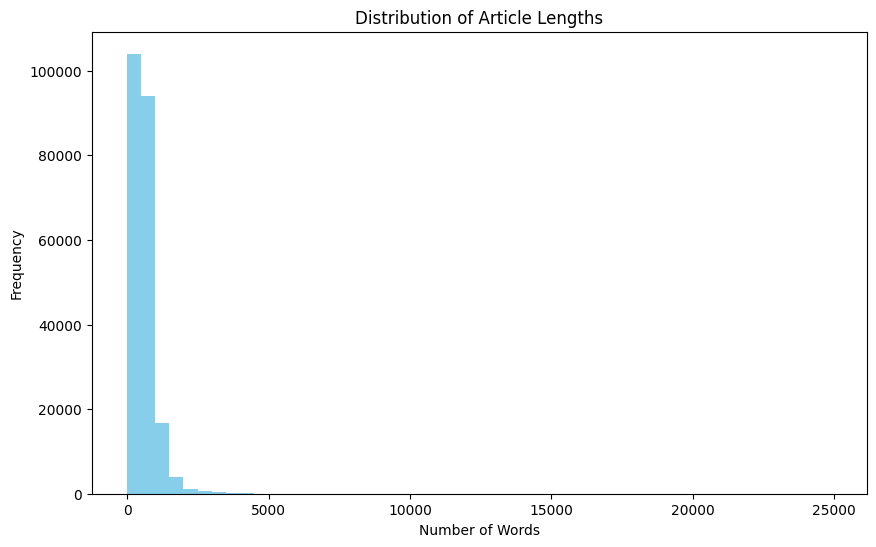

In [18]:
# Distribution of article lengths
plt.figure(figsize=(10, 6))
plt.hist(news_df['text_length'], bins=50, color='skyblue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Date range of the stock data
print("\nStock data date range:")
print(f"Start date: {stock_df['Date'].min()}")
print(f"End date: {stock_df['Date'].max()}")


Stock data date range:
Start date: 1999-01-25
End date: 2024-08-22


In [20]:

# Check the variance in stock prices to see how it might relate to news
stock_df['Price_Variance'] = stock_df['High'] - stock_df['Low']
print("\nSummary of Price Variance in Stock Data:")
print(stock_df['Price_Variance'].describe())


Summary of Price Variance in Stock Data:
count    6437.000000
mean        0.251577
std         0.781826
min         0.000390
25%         0.008917
50%         0.017750
75%         0.106500
max        13.350006
Name: Price_Variance, dtype: float64


In [ ]:
news_df['filtered_text'] = news_df['processed_text'].apply(
    lambda words: [word for word in words if word.isalpha() and word not in stop_words])

In [ ]:
# Join the filtered words back into strings for TF-IDF
news_df['filtered_text_str'] = news_df['filtered_text'].apply(lambda x: ' '.join(x))

In [21]:
# TF-IDF Representation of Documents using the processed and filtered text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(news_df['filtered_text_str'])

Exception ignored in: Exception ignored in sys.unraisablehook: <built-in function unraisablehook>
Traceback (most recent call last):
  File "C:\Users\georg\PycharmProjects\Stock-Movement-Prediction\venv\Lib\site-packages\ipykernel\iostream.py", line 694, in write
    self._schedule_flush()
  File "C:\Users\georg\PycharmProjects\Stock-Movement-Prediction\venv\Lib\site-packages\ipykernel\iostream.py", line 590, in _schedule_flush
    self.pub_thread.schedule(_schedule_in_thread)
  File "C:\Users\georg\PycharmProjects\Stock-Movement-Prediction\venv\Lib\site-packages\ipykernel\iostream.py", line 267, in schedule
    self._event_pipe.send(b"")
  File "C:\Users\georg\PycharmProjects\Stock-Movement-Prediction\venv\Lib\site-packages\zmq\sugar\socket.py", line 701, in send
    return super().send(data, flags=flags, copy=copy, track=track)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "_zmq.py", line 1092, in zmq.backend.cython._zmq.Socket.send
  File "_zmq.py", line 

KeyError: 'filtered_text_str'

In [ ]:
# TF-IDF Representation of Documents 

#Convert a collection of raw documents to a matrix of TF-IDF features. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(news_df['content'].dropna())

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(tfidf_matrix)

# Convert similarity matrix to a DataFrame for easier handling
similarity_df = pd.DataFrame(similarity_matrix)


In [ ]:
# Find indices of the most and least similar documents (excluding self-similarity)
np.fill_diagonal(similarity_matrix, 0)
most_similar_indices = np.unravel_index(np.argmax(similarity_matrix, axis=None), similarity_matrix.shape)
least_similar_indices = np.unravel_index(np.argmin(similarity_matrix, axis=None), similarity_matrix.shape)